In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/drive/MyDrive/data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)** 0.5)            #* 0.1  # for tanh
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # for saturated tanh
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for initial loss
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12297


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

# Context-manager that disables gradient calculation.
# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

  with torch.no_grad():  # bnmean_running and bnstd_running will be used just for testing so we will not be calling .backward()
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    # print(f"lr: {lr}, p.grad: {p.grad}")
    p.data += -lr* p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



  # break
# see if you will randomly initialize the b2 aand w2 then the initial loss will be very high this is because you are
# problem 1 :- Large Initial Loss
# problem 2 :- Saturated Tanh

      0/ 200000: 3.7900
  10000/ 200000: 2.1688
  20000/ 200000: 2.4154
  30000/ 200000: 2.4466
  40000/ 200000: 1.9891
  50000/ 200000: 2.3907
  60000/ 200000: 2.4331
  70000/ 200000: 2.0376
  80000/ 200000: 2.4163
  90000/ 200000: 2.1735
 100000/ 200000: 1.9519
 110000/ 200000: 2.3468
 120000/ 200000: 2.0179
 130000/ 200000: 2.4662
 140000/ 200000: 2.3045
 150000/ 200000: 2.1351
 160000/ 200000: 1.9420
 170000/ 200000: 1.7860
 180000/ 200000: 1.9887
 190000/ 200000: 1.9237


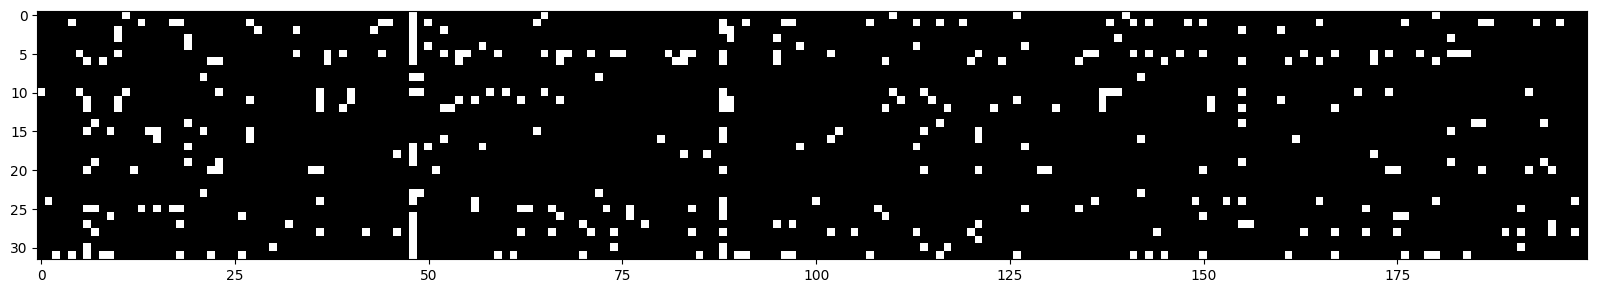

In [8]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest')

# white is showing that u are in the flat region of tanh so tanh(x)==1 and gradient will be zero so no update and neuron will be dead neuron

tensor(0.5010) tensor(0.2881)
tensor(-0.0368) tensor(0.5593)


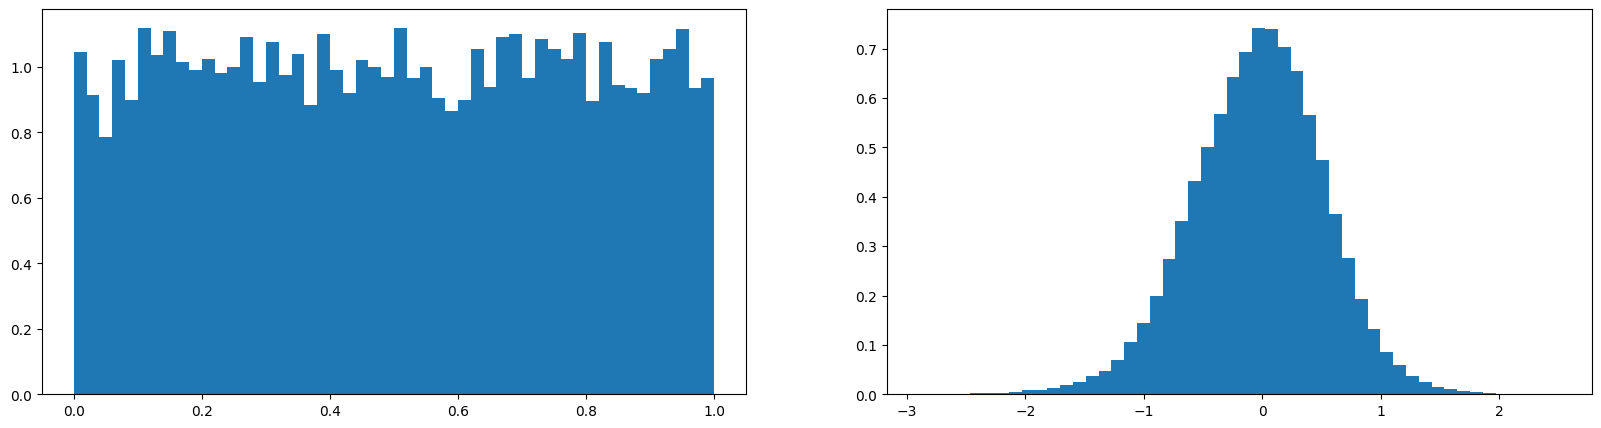

In [9]:
# code to see how multiplication of same type of distribution will increase the Standard Deivation and how we can we make secure it will remain same
x = torch. rand (1000, 10)
w = torch. randn (10, 200) / 10**0.5   # divided by root under fan_in
y = x@w
print (x.mean (), x.std())
print (y.mean(), y.std())
plt. figure (figsize=(20, 5))
plt. subplot (121)
plt. hist(x. view(-1).tolist(), 50, density=True);
plt. subplot (122)
plt.hist(y.view(-1). tolist(), 50,density=True);

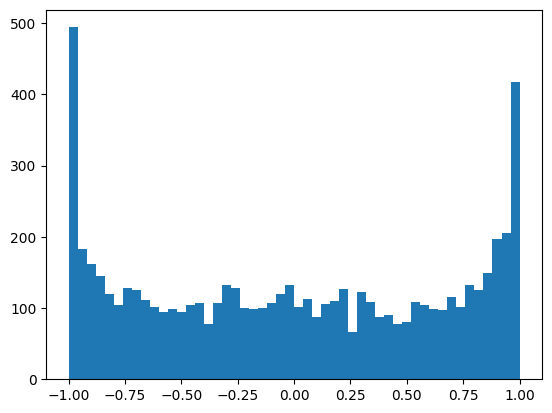

In [10]:
plt.hist(h.view(-1).tolist(), bins=50);

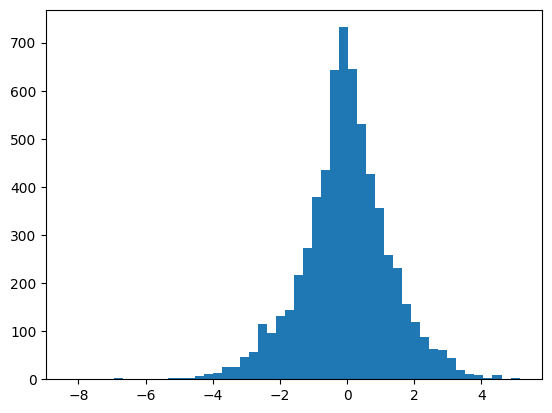

In [11]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

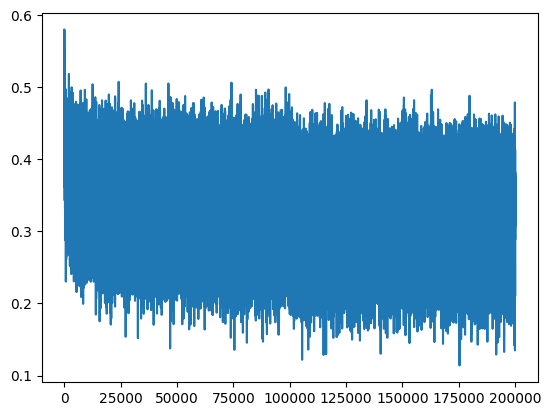

In [12]:
plt.plot(lossi)

In [13]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

# this will calculate the mean and std for entire data which we will we using to evaluate a single input
# bnmean_running and bnstd_running will be similiar/ very close to bnmean and bnstd which we calculated using this code
# we are caluclated bnmean_running and bnstd_running because it calculating side wise while training therefore we dont require a side code for calculating it

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
#
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0702574253082275
val 2.107924699783325


In [15]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # in case if we are using batch normalisation then we will bring change in gamma
  # layers[-1].weight *= 0.1  # scale down the weight of last layer
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3  # 2 or any bigger number then saturation will increase
                            # and for 1 saturation will decrease
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# len(layers)

47024


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1042
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2263
  60000/ 200000: 1.7340
  70000/ 200000: 2.1744
  80000/ 200000: 2.1895
  90000/ 200000: 1.8283
 100000/ 200000: 2.3643
 110000/ 200000: 2.2595
 120000/ 200000: 2.0967
 130000/ 200000: 1.8992
 140000/ 200000: 1.8313
 150000/ 200000: 1.9430
 160000/ 200000: 1.8673
 170000/ 200000: 1.8335
 180000/ 200000: 2.2503
 190000/ 200000: 2.0148


In [17]:
# put layers into eval mode (needed for batchnorm especially)
# no more training so no need to keep track of training
for layer in layers:
  layer.training = False

layer 2 (      Tanh): mean -0.01, std 0.70, saturated: 16.34%
layer 5 (      Tanh): mean -0.02, std 0.74, saturated: 19.19%
layer 8 (      Tanh): mean -0.00, std 0.77, saturated: 19.12%
layer 11 (      Tanh): mean +0.02, std 0.79, saturated: 20.84%
layer 14 (      Tanh): mean -0.01, std 0.81, saturated: 23.16%


Text(0.5, 1.0, 'activation distribution')

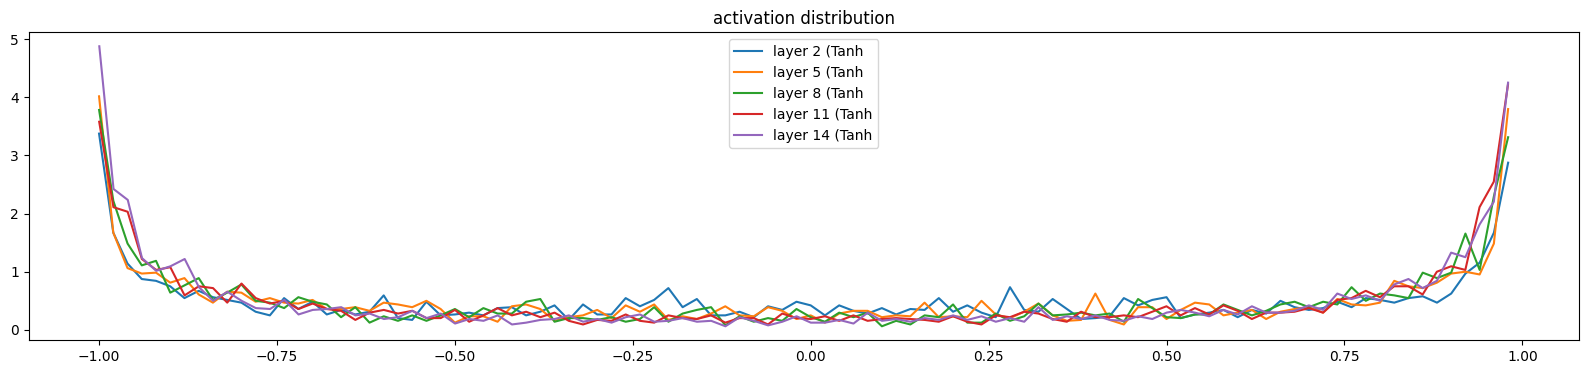

In [18]:
# visualize histograms
# percentage saturation is defined as % in tails of tanh
# if u will keep gain 5/3 then % saturation will be less as compared to gain = 5,6
# if u will keep gain =1 then as tanh is a squashing function so there will be nothing to encounter it and ultimately expect first layer everything will be squash to zero

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.181816e-03
layer 5 (      Tanh): mean +0.000000, std 3.067645e-03
layer 8 (      Tanh): mean +0.000000, std 3.130894e-03
layer 11 (      Tanh): mean +0.000000, std 3.453473e-03
layer 14 (      Tanh): mean +0.000000, std 3.800644e-03


Text(0.5, 1.0, 'gradient distribution')

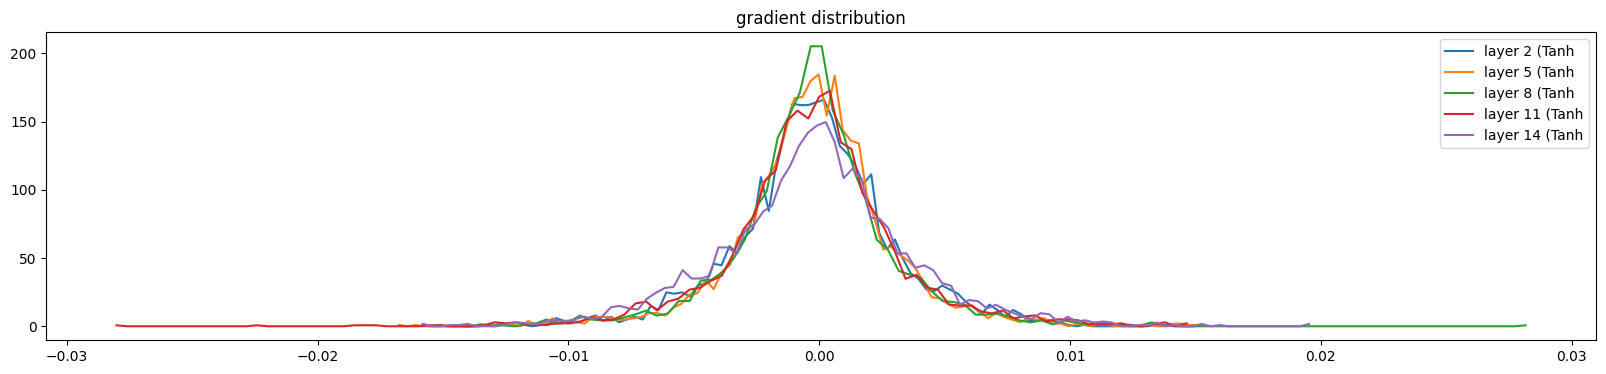

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.369385e-02 | grad:data ratio 1.194325e-02
weight  (30, 100) | mean +0.000061 | std 6.415255e-03 | grad:data ratio 1.430585e-02
weight (100, 100) | mean +0.000060 | std 4.184036e-03 | grad:data ratio 1.534861e-02
weight (100, 100) | mean -0.000077 | std 4.403574e-03 | grad:data ratio 1.640300e-02
weight (100, 100) | mean +0.000021 | std 4.558815e-03 | grad:data ratio 1.746765e-02
weight (100, 100) | mean -0.000019 | std 4.729692e-03 | grad:data ratio 1.877212e-02
weight  (100, 27) | mean +0.000046 | std 8.238951e-03 | grad:data ratio 2.210177e-02


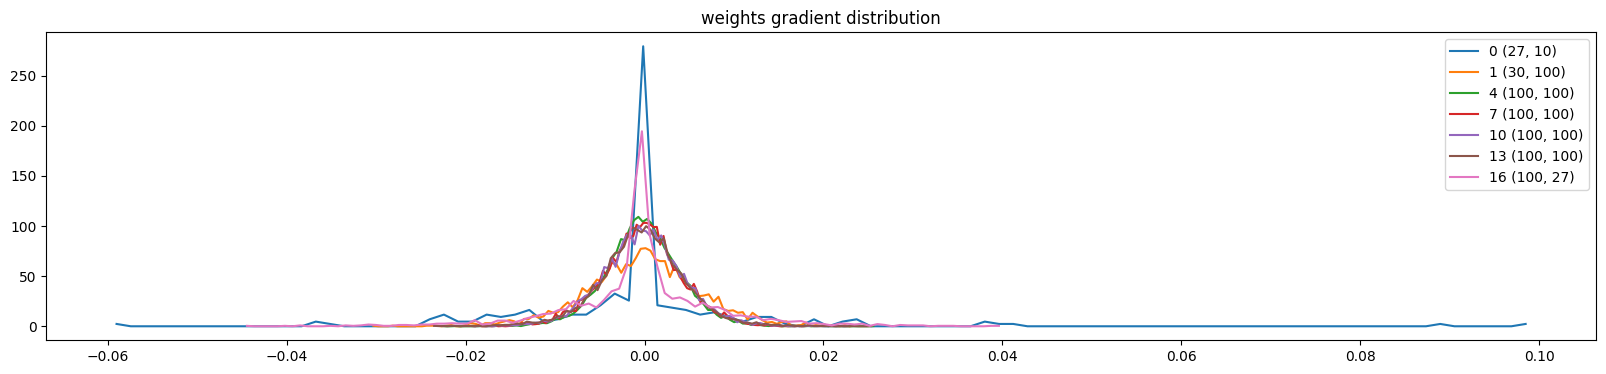

In [20]:
# visualize histograms
# sometimes visualising grad/data ratio is also important as u dont want ur grad to large in comparsion to ur data as ur model will starts behaving randomly and may not converage

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


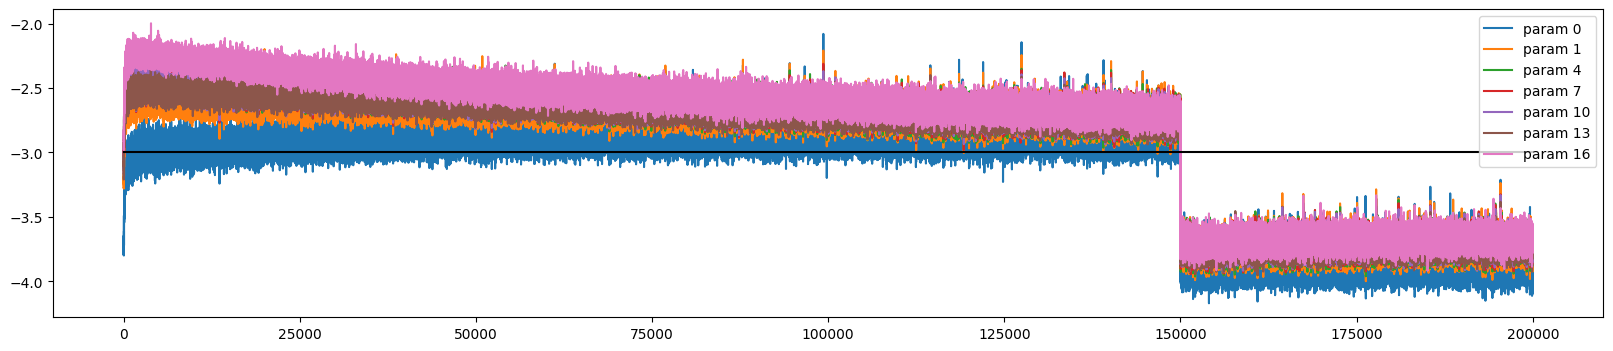

In [21]:
# updated value/input is sometimes more important
# u can notice a pink line too above than rest this is plot for last layer which intial giving too much update and now slowly reducing by the course of training
# this plot also tell about the learning rate if u will keep ur learning rate too small then all the update line will be below the base line

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:  # so that we get weights only as paramters
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot -> base line means itna update hon chaye
plt.legend(legends);

# sudden drop in graph is because we are reducing the learning rate after 150000 iteration

In [22]:
'''
make the different graphs in case of MLP , using pytorch and then using batchnormaisation
if u applied batch normalisation then affect of gain will reduce and using slightly smaller gain will also work
'''

'\nmake the different graphs in case of MLP , using pytorch and then using batchnormaisation\nif u applied batch normalisation then affect of gain will reduce and using slightly smaller gain will also work\n'

In [23]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0039474964141846
val 2.080599069595337


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhayla.
reisra.
ejdra.
grazered.
elin.
shivaelle.
elisson.
arleigh.
malaia.
noshubergiagriel.
kin.
renleigh.
terianuel.
ged.
ryylani.
elsy.
majahsanyah.
halisa.
